# Pneuomonia Recognition

Il nostro obiettivo è riuscire a classificare immagini di radiografie del torace in base alla presenza o assenza di polmonite.
Per eseguire questo task proveremo due diversi classificatori:
* Alberi decisionali con l'uso di Random Forest
* Convolutional Neural Networks

In [1]:
import numpy as np
X = np.load("pneumonia_images.npy")
y = np.load("pneumonia_labels.npy")

Visualizziamo alcune immagini del dataset, un target pari ad uno indica un caso di Polmonite, pari a 0 indica assenza di Polmonite

In [2]:
print("Number of images:", X.shape[0])
positive = 0
negative = 0

for i in range(X.shape[0]):
    if(y[i]==1):
        positive += 1
    if(y[i]==0):
        negative += 1

print("Number of positive cases:", positive)
print("Number of negative cases:", negative)

Number of images: 5232
Number of positive cases: 3883
Number of negative cases: 1349


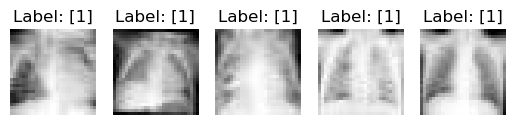

In [3]:
import matplotlib.pyplot as plt


# Visualizza alcune immagini
num_images_to_display = 5

for i in range(num_images_to_display):
    # Seleziona un'immagine casuale
    index = np.random.randint(0, len(X))
    image = X[index]
    label = y[index]

    # Visualizza l'immagine con la sua etichetta
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

Il dataset è sbilanciato verso le immagini con polmonite:

Circa il 74.2% delle immagini rappresentano casi di polmonite.
Circa il 25.8% delle immagini rappresentano casi negativi.

Andiamo a suddividere il train set tra training e test, utilizzando stratify per mantenere proporzione tra le classi

In [4]:
from sklearn.model_selection import train_test_split

# Suddivisione in set di addestramento e set di validazione
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

A questo punto andiamo a dividere il Training Set in Training e Validation, mantenendo la stessa proporzione

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [6]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_valid.reshape(X_valid.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [7]:
import numpy as np

print("Valore minimo dei pixel:", np.min(X_train_reshaped))
print("Valore massimo dei pixel:", np.max(X_train_reshaped))

Valore minimo dei pixel: 0
Valore massimo dei pixel: 255


Vado a normalizzare i dati dopo aver suddiviso Training, Validation e Test per evitare Data Leakage.
Essendo immagini in scala di grigi, possiamo semplicemente dividere il valore dei pixel per 255.

In [8]:
# Normalizzazione delle immagini in scala di grigi
X_train_normalized = X_train / 255.0
X_val_normalized = X_valid / 255.0
X_test_normalized = X_test / 255.0

In [9]:
import numpy as np

print("Valore minimo dei pixel:", np.min(X_train_normalized))
print("Valore massimo dei pixel:", np.max(X_train_normalized))

Valore minimo dei pixel: 0.0
Valore massimo dei pixel: 1.0


In [10]:
print(f'Original X_train shape: {X_train.shape}')
print(f'Normalized X_train shape: {X_train_normalized.shape}')

print(f'Original X_val shape: {X_valid.shape}')
print(f'Normalized X_val shape: {X_val_normalized.shape}')

print(f'Original X_test shape: {X_test.shape}')
print(f'Normalized X_test shape: {X_test_normalized.shape}')

Original X_train shape: (3348, 28, 28)
Normalized X_train shape: (3348, 28, 28)
Original X_val shape: (837, 28, 28)
Normalized X_val shape: (837, 28, 28)
Original X_test shape: (1047, 28, 28)
Normalized X_test shape: (1047, 28, 28)


## Alberi decisionali

Cominciamo con un semplice Albero Decisionale, vado quindi ad appiattire i miei dati e usiamo Ravel sui target per trasformarli in vettori 1D

In [11]:
X_train_flatten = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_val_flatten = X_val_normalized.reshape(X_val_normalized.shape[0], -1)
X_test_flatten = X_test_normalized.reshape(X_test_normalized.shape[0], -1)
y_train_ravel = y_train.ravel()
y_valid_ravel = y_valid.ravel()
y_test_ravel = y_test.ravel()
print(f"Flattened training set size: {X_train_flatten.shape}")
print(f"Flattened validation set size: {X_val_flatten.shape}")
print(f"Flattened test set size: {X_test_flatten.shape}")
print(f"Train set label size: {y_train.shape}")
print(f"Validation set label size: {y_valid.shape}")
print(f"Test set label size: {y_test.shape}")

Flattened training set size: (3348, 784)
Flattened validation set size: (837, 784)
Flattened test set size: (1047, 784)
Train set label size: (3348, 1)
Validation set label size: (837, 1)
Test set label size: (1047, 1)


Visto il numero esiguo di dati, usiamo per testare il modello Cross-Validation, utilizzando la Cross-Validation, è possibile ottenere stime più realistiche delle prestazioni del modello su dati non visti.

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

Scores della cross-validation (F1): [0.94081633 0.936      0.93055556 0.9416499  0.94259819]
Media della cross-validation (F1): 0.94 (+/- 0.01)
F1-score sul set di validazione: 0.93
F1-score sul set di test: 0.93

Matrice di Confusione sul set di test:


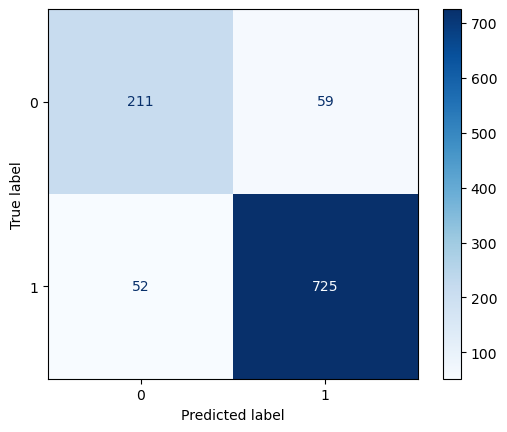

In [13]:
clf = DecisionTreeClassifier()
cv_scores = cross_val_score(clf, X_train_flatten, y_train_ravel, cv=5, scoring='f1')

# Stampare i punteggi ottenuti dalla cross-validation
print("Scores della cross-validation (F1):", cv_scores)
print(f"Media della cross-validation (F1): {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Passo 3: Addestra il modello sul set di addestramento completo
clf.fit(X_train_flatten, y_train_ravel)

# Passo 4: Valida il modello sul set di validazione
y_val_pred = clf.predict(X_val_flatten)
val_f1 = f1_score(y_valid_ravel, y_val_pred)
print(f"F1-score sul set di validazione: {val_f1:.2f}")

# Passo 5: Valuta definitivamente il modello sul set di test
y_test_pred = clf.predict(X_test_flatten)
test_conf_matrix = confusion_matrix(y_test_ravel, y_test_pred)
test_f1 = f1_score(y_test_ravel, y_test_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")
print("\nMatrice di Confusione sul set di test:")
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


### Random Forest

Per migliorare l'accuratezza del modello, proviamo l'uso di Random Forest, applichiamo quindi la tecnica del Bagging sugli alberi decisionali.

Scores della cross-validation (F1): [0.96981891 0.968      0.95575221 0.9740519  0.96831683]
Media della cross-validation (F1): 0.97 (+/- 0.01)
F1-score sul set di validazione: 0.96
F1-score sul set di test: 0.96

Matrice di Confusione sul set di test:


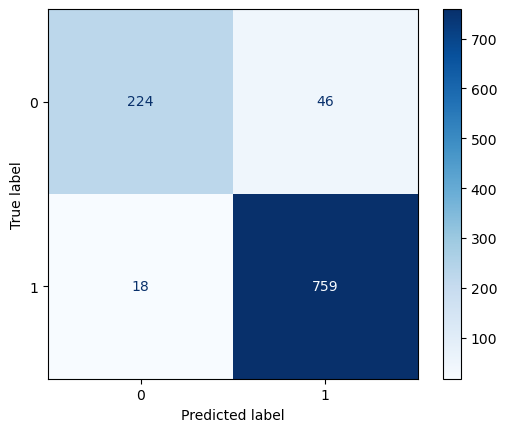

In [14]:
from sklearn.ensemble import RandomForestClassifier

randomFC = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(randomFC, X_train_flatten, y_train_ravel, cv=5, scoring='f1')

# Stampare i punteggi ottenuti dalla cross-validation
print("Scores della cross-validation (F1):", cv_scores)
print(f"Media della cross-validation (F1): {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Passo 3: Addestra il modello sul set di addestramento completo
randomFC.fit(X_train_flatten, y_train_ravel)

# Passo 4: Valida il modello sul set di validazione
y_val_pred = randomFC.predict(X_val_flatten)
val_f1 = f1_score(y_valid_ravel, y_val_pred)
print(f"F1-score sul set di validazione: {val_f1:.2f}")

# Passo 5: Valuta definitivamente il modello sul set di test
y_test_pred = randomFC.predict(X_test_flatten)
test_conf_matrix = confusion_matrix(y_test_ravel, y_test_pred)
test_f1 = f1_score(y_test_ravel, y_test_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")
print("\nMatrice di Confusione sul set di test:")
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### RandomizedSearchCV

Usare GridSearch per trovare i migliori parametri su Random Forest richiederebbe una quantità di tempo troppo elevata, usiamo quindi RandomizedSearchCV che va a campionare un numero fissato di impostazioni dei parametri da una distribuzione di probabilità piuttosto che cercare ogni combinazione possibile.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

randomFCRSRS = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(100, 800),
    'max_depth': [10, 20, 30, 40],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

random_search = RandomizedSearchCV(estimator=randomFCRSRS, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_flatten, y_train_ravel)

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

Creiamo il modello con i parametri trovati tramite la RandomizedSearchCV

Scores della cross-validation (F1): [0.97183099 0.96503497 0.95874263 0.97415507 0.96442688]
Media della cross-validation (F1): 0.97 (+/- 0.01)
F1-score sul set di validazione: 0.96
F1-score sul set di test: 0.96

Matrice di Confusione sul set di test:


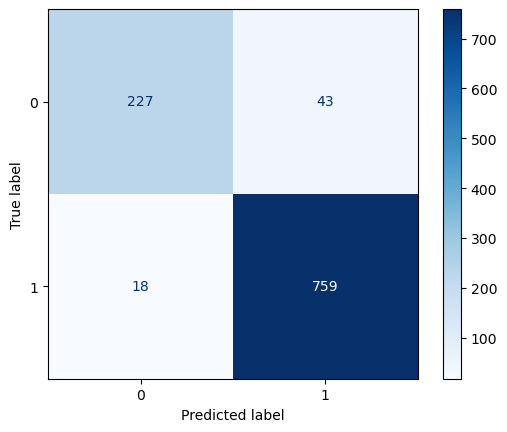

In [15]:
# Migliori parametri ottenuti dalla ricerca
best_params = {
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 6,
    'n_estimators': 589,
    'random_state': 42
}

# Creare un nuovo modello con i parametri ottimali
best_model = RandomForestClassifier(**best_params)

cv_scores = cross_val_score(best_model, X_train_flatten, y_train_ravel, cv=5, scoring='f1')

# Stampare i punteggi ottenuti dalla cross-validation
print("Scores della cross-validation (F1):", cv_scores)
print(f"Media della cross-validation (F1): {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Passo 3: Addestra il modello sul set di addestramento completo
best_model.fit(X_train_flatten, y_train_ravel)

# Passo 4: Valida il modello sul set di validazione
y_val_pred = best_model.predict(X_val_flatten)
val_f1 = f1_score(y_valid_ravel, y_val_pred)
print(f"F1-score sul set di validazione: {val_f1:.2f}")

# Passo 5: Valuta definitivamente il modello sul set di test
y_test_pred = best_model.predict(X_test_flatten)
test_conf_matrix = confusion_matrix(y_test_ravel, y_test_pred)
test_f1 = f1_score(y_test_ravel, y_test_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")
print("\nMatrice di Confusione sul set di test:")
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Anche se con piccole differenze rispetto ai precedenti, notiamo che questo è il migliori risultato che siamo riusciti ad ottenere.

## Convolutional Neural Networks

Andiamo a eseguire il Training tramite Convolutional Neural Networks, utilizziamo una semplice CNN composta da 2 strati convoluzionali e uno strato Dense da 128 unità per la classificazione binaria, quest'ultima realizzata con un livello Dense di 1 unità con funzione di attivazione sigmoid.

Inanzitutto, vista la diversa gestione delle metriche di tensorflow rispetto a scikit-learn, implementiamo una metrica F1-Score personalizzata:
Calcoliamo quindi separatamente, la recall e la precision, e implementiamo la F1 come: $$ F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall} $$


In [16]:
from tensorflow.keras import backend as K

# Funzione per calcolare l'F1-score
def f1_score_personalized(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1

Ora definiamo una funzione per la stampa dei vari grafici, necessari durante il Training

In [17]:
import matplotlib.pyplot as plt

def graphics(history):
    plt.figure(figsize=(12, 4))

    # Plot della perdita
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot delle metriche
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['f1_score_personalized'], label='Training F1 Score')
    plt.plot(history.history['val_f1_score_personalized'], label='Validation F1 Score')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.show()

#### Early Stopping
Inseriamo l'Early Stopping, una tecnica utilizzata durante l'addestramento dei modelli di machine learning per migliorare l'efficienza e prevenire l'overfitting, la inserisco da subito visto anche il beneficio computazionale.

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Definizione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

In [20]:
cnn1 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [21]:
# Stampa una rappresentazione del modello
cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [22]:
# Compilazione del modello
cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_personalized])

In [23]:
history = cnn1.fit(X_train_normalized, y_train, epochs=50, batch_size=32, 
                   validation_data=(X_val_normalized, y_valid),
                   callbacks=[early_stopping])

Epoch 1/50
105/105 [==============================] - 6s 47ms/step - loss: 0.4866 - accuracy: 0.7736 - f1_score_personalized: 0.8607 - val_loss: 0.4145 - val_accuracy: 0.8172 - val_f1_score_personalized: 0.8502
Epoch 2/50
105/105 [==============================] - 4s 42ms/step - loss: 0.2054 - accuracy: 0.9155 - f1_score_personalized: 0.9421 - val_loss: 0.2016 - val_accuracy: 0.9164 - val_f1_score_personalized: 0.9377
Epoch 3/50
105/105 [==============================] - 4s 41ms/step - loss: 0.1516 - accuracy: 0.9418 - f1_score_personalized: 0.9602 - val_loss: 0.1536 - val_accuracy: 0.9427 - val_f1_score_personalized: 0.9565
Epoch 4/50
105/105 [==============================] - 4s 39ms/step - loss: 0.1309 - accuracy: 0.9483 - f1_score_personalized: 0.9642 - val_loss: 0.1373 - val_accuracy: 0.9403 - val_f1_score_personalized: 0.9546
Epoch 5/50
105/105 [==============================] - 5s 46ms/step - loss: 0.1206 - accuracy: 0.9558 - f1_score_personalized: 0.9697 - val_loss: 0.1443 - va

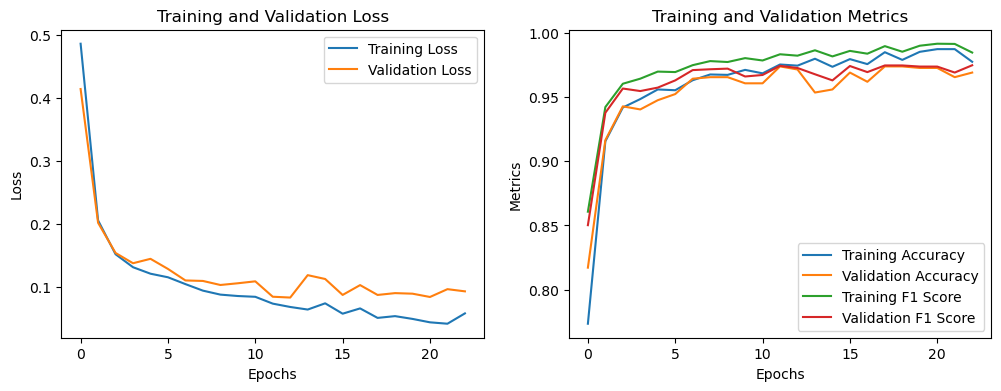

In [24]:
graphics(history)

33/33 [==============================] - 0s 2ms/step
F1-score sul set di test: 0.98


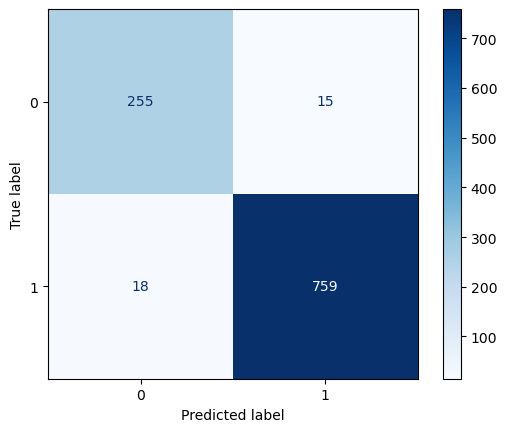

In [25]:
y_pred_prob = cnn1.predict(X_test_normalized)
y_pred = np.round(y_pred_prob).astype(int)  # Converti y_pred in int32 
# Calcola l'F1-score utilizzando la funzione f1_score modificata
test_f1 = f1_score(y_test, y_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")

# Calcola la confusion matrix utilizzando y_valid e y_pred
cm = confusion_matrix(y_test, y_pred)

# Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Il modello, dalla curva riguardante la Validation Loss, mostra qualche segno di **overfitting**, vista la dimensione ridotta del training set, applichiamo **Data Augmentation** per renderlo più corposo. Per immagini mediche non è raccomandato l'uso di flip orizzontali, evitiamo quindi il suo utilizzo tra le possibili variazioni.

Data Augmentation richiede che le immagini abbiano una dimensione aggiuntiva che rappresenti il canale dei colori, vado quindi ad espandere il dataset aggiungendola

In [26]:
X_train_expand = np.expand_dims(X_train_normalized, axis=-1)
X_val_expand = np.expand_dims(X_val_normalized, axis=-1)
X_test_expand = np.expand_dims(X_test_normalized, axis=-1)

In [79]:
print(f'New shape: {X_train_expand.shape}')

New shape: (3348, 28, 28, 1)


### Data Augmentation

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=False,  # Non riflettere lungo l'asse x per immagini mediche
    fill_mode='nearest'
)

# Definisci il generatore di dati per il set di validazione senza data augmentation
val_datagen = ImageDataGenerator()

# Assicurati di adattare i generatori ai tuoi dati
train_generator = train_datagen.flow(X_train_expand, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_expand, y_valid, batch_size=32)

Andiamo a vedere un paragone tra le immagini reali, e le immagini generate tramite il generatore.

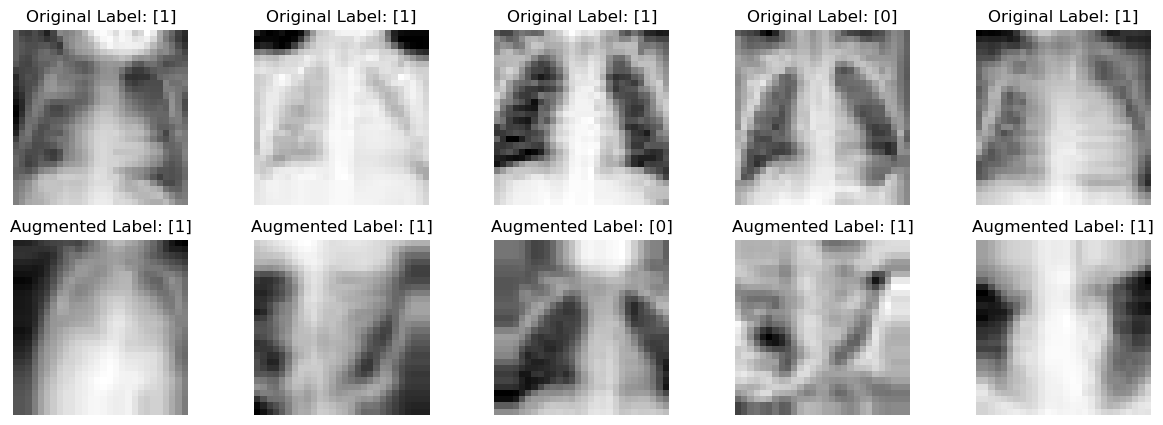

In [28]:
# Visualizza alcune immagini originali
num_images_to_display = 5
plt.figure(figsize=(15, 5))

for i in range(num_images_to_display):
    # Seleziona un'immagine casuale
    index = np.random.randint(0, len(X_train))
    original_image = X_train[index]
    original_label = y_train[index]

    # Visualizza l'immagine originale con la sua etichetta
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original Label: {original_label}")
    plt.axis('off')

# Visualizza alcune immagini generate
for i in range(num_images_to_display):
    augmented_data = next(train_generator)
    augmented_image = augmented_data[0][0]  # Ottieni l'immagine generata
    augmented_label = augmented_data[1][0]  # Ottieni l'etichetta generata

    # Visualizza l'immagine generata con la sua etichetta
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.title(f"Augmented Label: {augmented_label}")
    plt.axis('off')

plt.show()

Andiamo a trainare lo stesso modello precedentemente usato, ma usandolo su un dataset più grande

In [33]:
cnn1_augmentation = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [34]:
cnn1_augmentation.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_personalized])

history = cnn1_augmentation.fit(
    train_generator,
    steps_per_epoch=len(X_train_expand) // 32,
    epochs=80,
    validation_data=val_generator,
    validation_steps=len(X_val_expand) // 32,
    callbacks=[early_stopping]
)

Epoch 1/80
104/104 [==============================] - 7s 51ms/step - loss: 0.4697 - accuracy: 0.7805 - f1_score_personalized: 0.8650 - val_loss: 0.3695 - val_accuracy: 0.8245 - val_f1_score_personalized: 0.8652
Epoch 2/80
104/104 [==============================] - 5s 51ms/step - loss: 0.2870 - accuracy: 0.8709 - f1_score_personalized: 0.9122 - val_loss: 0.2443 - val_accuracy: 0.9002 - val_f1_score_personalized: 0.9309
Epoch 3/80
104/104 [==============================] - 5s 49ms/step - loss: 0.2373 - accuracy: 0.8960 - f1_score_personalized: 0.9287 - val_loss: 0.2292 - val_accuracy: 0.9050 - val_f1_score_personalized: 0.9327
Epoch 4/80
104/104 [==============================] - 6s 55ms/step - loss: 0.2311 - accuracy: 0.9005 - f1_score_personalized: 0.9320 - val_loss: 0.2183 - val_accuracy: 0.9087 - val_f1_score_personalized: 0.9354
Epoch 5/80
104/104 [==============================] - 5s 52ms/step - loss: 0.2039 - accuracy: 0.9113 - f1_score_personalized: 0.9397 - val_loss: 0.2596 - va

Epoch 40/80
104/104 [==============================] - 5s 50ms/step - loss: 0.0977 - accuracy: 0.9617 - f1_score_personalized: 0.9735 - val_loss: 0.1091 - val_accuracy: 0.9495 - val_f1_score_personalized: 0.9652
Epoch 41/80
104/104 [==============================] - 6s 53ms/step - loss: 0.0910 - accuracy: 0.9653 - f1_score_personalized: 0.9763 - val_loss: 0.1567 - val_accuracy: 0.9459 - val_f1_score_personalized: 0.9616
Epoch 42/80
104/104 [==============================] - 6s 54ms/step - loss: 0.0900 - accuracy: 0.9641 - f1_score_personalized: 0.9748 - val_loss: 0.0833 - val_accuracy: 0.9675 - val_f1_score_personalized: 0.9785
Epoch 43/80
104/104 [==============================] - 6s 56ms/step - loss: 0.0910 - accuracy: 0.9674 - f1_score_personalized: 0.9775 - val_loss: 0.1022 - val_accuracy: 0.9627 - val_f1_score_personalized: 0.9750
Epoch 44/80
104/104 [==============================] - 6s 59ms/step - loss: 0.1011 - accuracy: 0.9611 - f1_score_personalized: 0.9732 - val_loss: 0.1598

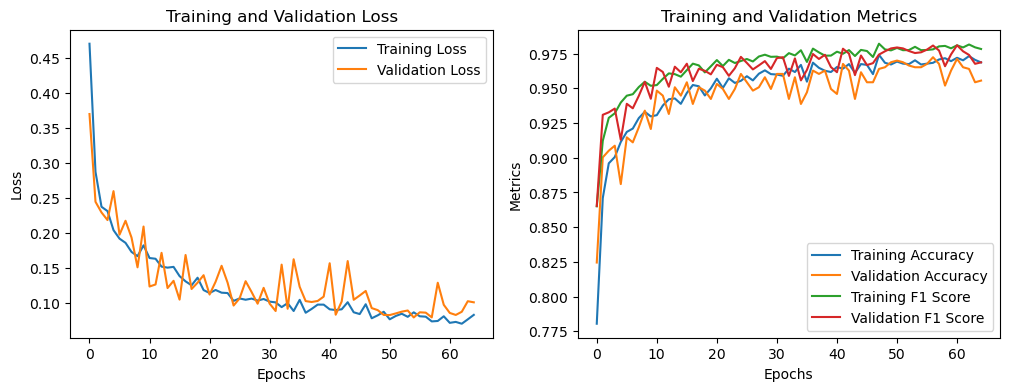

In [36]:
graphics(history)

33/33 [==============================] - 0s 4ms/step
F1-score sul set di test: 0.98


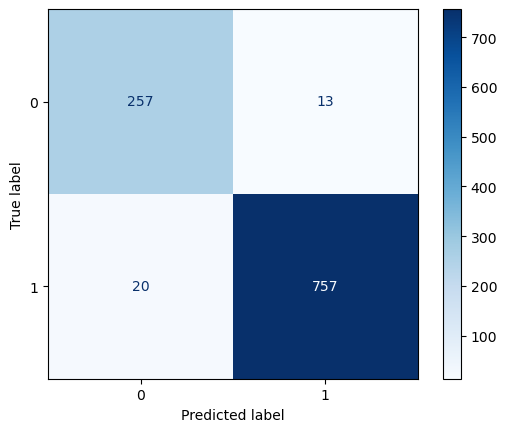

In [37]:
y_pred_prob = cnn1_augmentation.predict(X_test_expand)
y_pred = np.round(y_pred_prob).astype(int)  # Converti y_pred in int32 
# Calcola l'F1-score utilizzando la funzione f1_score modificata
test_f1 = f1_score(y_test, y_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")

# Calcola la confusion matrix utilizzando y_valid e y_pred
cm = confusion_matrix(y_test, y_pred)

# Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Proviamo ora un modello più performante, scegliendo un modello VGG-Like:
* Aumento del numero di filtri: Ogni blocco di convoluzione ha un numero crescente di filtri, raddoppiando tipicamente il numero di filtri dopo ogni operazione di pooling.
* Blocco convoluzionale seguito da pooling: Dopo ogni serie di strati convoluzionali, c'è un'operazione di max pooling per ridurre la dimensione spaziale.

In [49]:
cnn2 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(6, 6),strides=2),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [50]:
# Compilazione del modello
cnn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_personalized])

cnn2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 10, 10, 32)        4640      
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                 

In [51]:
history2 = cnn2.fit(
    train_generator,
    steps_per_epoch=len(X_train_expand) // 32,
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(X_val_expand) // 32,
    callbacks=[early_stopping]
)

Epoch 1/100
104/104 [==============================] - 10s 74ms/step - loss: 0.4616 - accuracy: 0.7973 - f1_score_personalized: 0.8709 - val_loss: 0.3124 - val_accuracy: 0.8570 - val_f1_score_personalized: 0.8940
Epoch 2/100
104/104 [==============================] - 9s 89ms/step - loss: 0.2698 - accuracy: 0.8791 - f1_score_personalized: 0.9156 - val_loss: 0.3431 - val_accuracy: 0.8281 - val_f1_score_personalized: 0.8700
Epoch 3/100
104/104 [==============================] - 11s 110ms/step - loss: 0.2837 - accuracy: 0.8755 - f1_score_personalized: 0.9148 - val_loss: 0.2642 - val_accuracy: 0.8870 - val_f1_score_personalized: 0.9221
Epoch 4/100
104/104 [==============================] - 9s 86ms/step - loss: 0.2374 - accuracy: 0.8984 - f1_score_personalized: 0.9302 - val_loss: 0.2798 - val_accuracy: 0.8750 - val_f1_score_personalized: 0.9096
Epoch 5/100
104/104 [==============================] - 8s 75ms/step - loss: 0.2460 - accuracy: 0.8935 - f1_score_personalized: 0.9279 - val_loss: 0.2

104/104 [==============================] - 6s 62ms/step - loss: 0.1054 - accuracy: 0.9572 - f1_score_personalized: 0.9709 - val_loss: 0.1235 - val_accuracy: 0.9567 - val_f1_score_personalized: 0.9703
Epoch 40/100
104/104 [==============================] - 6s 58ms/step - loss: 0.0947 - accuracy: 0.9650 - f1_score_personalized: 0.9760 - val_loss: 0.0934 - val_accuracy: 0.9627 - val_f1_score_personalized: 0.9741
Epoch 41/100
104/104 [==============================] - 6s 61ms/step - loss: 0.1013 - accuracy: 0.9614 - f1_score_personalized: 0.9741 - val_loss: 0.0946 - val_accuracy: 0.9663 - val_f1_score_personalized: 0.9767
Epoch 42/100
104/104 [==============================] - 6s 61ms/step - loss: 0.0902 - accuracy: 0.9644 - f1_score_personalized: 0.9753 - val_loss: 0.1030 - val_accuracy: 0.9567 - val_f1_score_personalized: 0.9706
Epoch 43/100
104/104 [==============================] - 6s 59ms/step - loss: 0.0914 - accuracy: 0.9635 - f1_score_personalized: 0.9750 - val_loss: 0.1325 - val_a

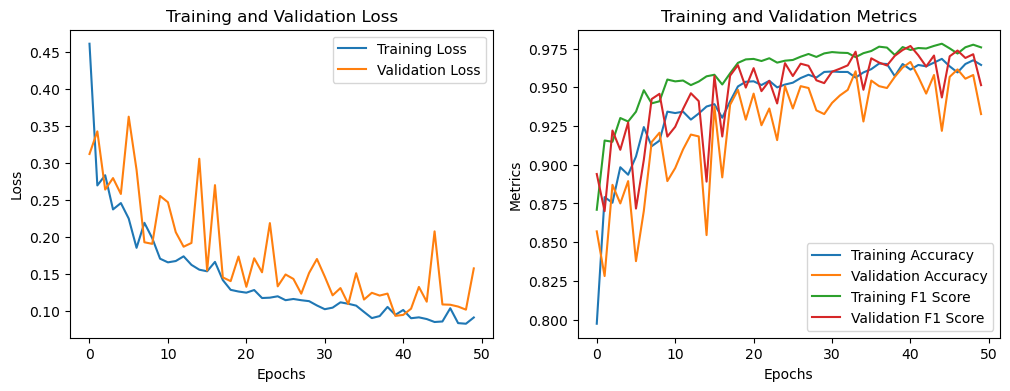

In [52]:
graphics(history2)

33/33 [==============================] - 0s 6ms/step
F1-score sul set di test: 0.97


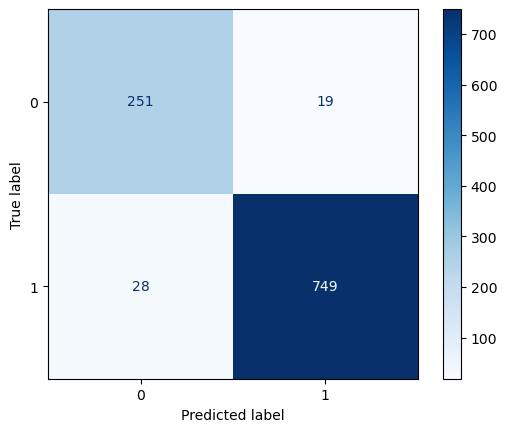

In [53]:
y_pred_prob = cnn2.predict(X_test_expand)
y_pred = np.round(y_pred_prob).astype(int)  # Converti y_pred in int32 
# Calcola l'F1-score utilizzando la funzione f1_score modificata
test_f1 = f1_score(y_test, y_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")

# Calcola la confusion matrix utilizzando y_valid e y_pred
cm = confusion_matrix(y_test, y_pred)

# Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Notiamo una certa  instabilità nel training, aggiungiamo alcuni strumenti per migliorare la convergenza:
* **He Normalization**: metodo di inizializzazione dei pesi delle reti neurali, che sembra funzionare molto bene con ReLU
* **L2**: tecnica di regolarizzazione che va ad aggiungere un termine alla funzione di perdita che penalizza i pesi grandi, forzandoli a rimanere piccoli durante l'addestramento
* **ReduceLROnPlateau**: callback di Keras che riduce il tasso di apprendimento (learning rate) quando una metrica monitorata smette di migliorare. È utile per accelerare il processo di addestramento e migliorare la convergenza del modello.
* **BatchNormalization**: tecnica che normalizza i valori di attivazione tra i layer di una rete neurale, rendendo l'addestramento più veloce e stabile. Aiuta anche a prevenire l'overfitting.

In [54]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal

In [59]:
cnn2_tune = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal()),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    Dense(1, activation='sigmoid')
])

In [60]:
# Compilazione del modello
cnn2_tune.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_personalized])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn2_tune.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                      

In [61]:
history = cnn2_tune.fit(
    train_generator,
    steps_per_epoch=len(X_train_expand) // 32,
    epochs=120,
    validation_data=val_generator,
    validation_steps=len(X_val_expand) // 32,
    callbacks=([early_stopping],[reduce_lr])
)

Epoch 1/120
104/104 [==============================] - 10s 65ms/step - loss: 1.1912 - accuracy: 0.9092 - f1_score_personalized: 0.9350 - val_loss: 2.0215 - val_accuracy: 0.7416 - val_f1_score_personalized: 0.8499 - lr: 0.0010
Epoch 2/120
104/104 [==============================] - 6s 58ms/step - loss: 0.8586 - accuracy: 0.9436 - f1_score_personalized: 0.9609 - val_loss: 1.1233 - val_accuracy: 0.7945 - val_f1_score_personalized: 0.8766 - lr: 0.0010
Epoch 3/120
104/104 [==============================] - 6s 53ms/step - loss: 0.6617 - accuracy: 0.9472 - f1_score_personalized: 0.9642 - val_loss: 0.7970 - val_accuracy: 0.8606 - val_f1_score_personalized: 0.9122 - lr: 0.0010
Epoch 4/120
104/104 [==============================] - 6s 53ms/step - loss: 0.5285 - accuracy: 0.9487 - f1_score_personalized: 0.9652 - val_loss: 0.4680 - val_accuracy: 0.9543 - val_f1_score_personalized: 0.9682 - lr: 0.0010
Epoch 5/120
104/104 [==============================] - 5s 52ms/step - loss: 0.4239 - accuracy: 0.95

104/104 [==============================] - 5s 50ms/step - loss: 0.0995 - accuracy: 0.9792 - f1_score_personalized: 0.9859 - val_loss: 0.1686 - val_accuracy: 0.9543 - val_f1_score_personalized: 0.9676 - lr: 0.0010
Epoch 38/120
104/104 [==============================] - 5s 51ms/step - loss: 0.0977 - accuracy: 0.9822 - f1_score_personalized: 0.9878 - val_loss: 0.1264 - val_accuracy: 0.9675 - val_f1_score_personalized: 0.9775 - lr: 1.0000e-04
Epoch 39/120
104/104 [==============================] - 5s 49ms/step - loss: 0.0912 - accuracy: 0.9792 - f1_score_personalized: 0.9856 - val_loss: 0.1273 - val_accuracy: 0.9688 - val_f1_score_personalized: 0.9788 - lr: 1.0000e-04
Epoch 40/120
104/104 [==============================] - 6s 59ms/step - loss: 0.0854 - accuracy: 0.9855 - f1_score_personalized: 0.9900 - val_loss: 0.1241 - val_accuracy: 0.9675 - val_f1_score_personalized: 0.9776 - lr: 1.0000e-04
Epoch 41/120
104/104 [==============================] - 6s 59ms/step - loss: 0.0816 - accuracy: 0

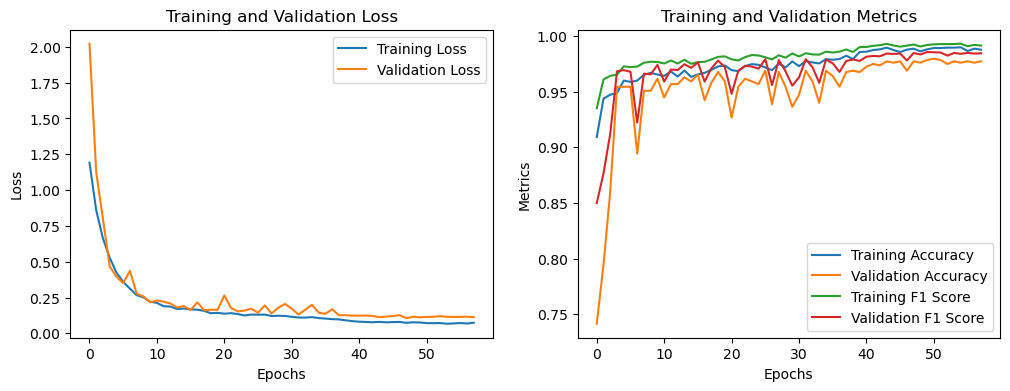

In [63]:
graphics(history)

33/33 [==============================] - 1s 7ms/step
F1-score sul set di test: 0.97


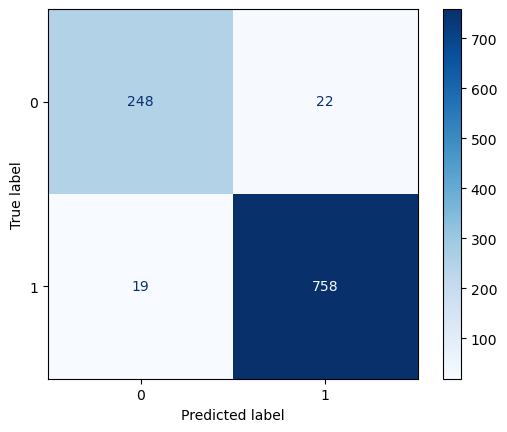

In [64]:
y_pred_prob = cnn2_tune.predict(X_test_expand)
y_pred = np.round(y_pred_prob).astype(int)  # Converti y_pred in int32 
# Calcola l'F1-score utilizzando la funzione f1_score modificata
test_f1 = f1_score(y_test, y_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")

# Calcola la confusion matrix utilizzando y_valid e y_pred
cm = confusion_matrix(y_test, y_pred)

# Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Keras Tuner

Proviamo a migliorare ulteriormente le metriche di valutazione, eseguendo tuning degli iperparametri attraverso Keras Tuner

In [115]:
from keras.layers import Activation
def build_model(hp):
    model = Sequential()

    # Primo layer convoluzionale
    model.add(Conv2D(hp.Int('input_units',
                            min_value=8,
                            max_value=256,
                            step=32), 
                     (3, 3), 
                     input_shape=(28, 28, 1),
                     kernel_regularizer=l2(0.001),
                     kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Aggiungi ulteriori layer convoluzionali
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), 
                         (3, 3),
                         kernel_regularizer=l2(0.001),
                         kernel_initializer=he_normal()))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    # Aggiungi layer densi
    for i in range(hp.Int('n_connections', 1, 4)):
        model.add(Dense(hp.Choice(f'n_nodes',
                                  values=[128, 256, 512, 1024]),
                        kernel_regularizer=l2(0.001),
                        kernel_initializer=he_normal()))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

    model.add(Dense(1, kernel_regularizer=l2(0.001), kernel_initializer=he_normal()))
    model.add(Activation("sigmoid"))

    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", f1_score_personalized])

    return model

In [116]:
from keras_tuner.tuners import RandomSearch
from keras_tuner import Objective

tuner = RandomSearch(
    build_model,
    objective=Objective('val_f1_score_personalized', direction='max'),
    max_trials=10,  # Numero di combinazioni di iperparametri da provare
    executions_per_trial=1,  # Esecuzioni per ogni combinazione di iperparametri
    directory='my_dir',
    project_name='cnn_newtuning'
)

# Esegui la ricerca degli iperparametri
tuner.search(X_train_expand, y_train, epochs=60, validation_data=(X_val_expand, y_valid))


Trial 10 Complete [00h 12m 59s]
val_f1_score_personalized: 0.9687644243240356

Best val_f1_score_personalized So Far: 0.9747462868690491
Total elapsed time: 02h 16m 23s


Best parameters found: {'input_units': 232, 'n_layers': 1, 'conv_0_units': 128, 'n_connections': 1, 'n_nodes': 256, 'conv_1_units': 192, 'conv_2_units': 128, 'conv_3_units': 128}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 232)       2320      
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 232)      928       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 232)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 232)      0         
 )                                                               
                                                                 
 conv2d_1

33/33 [==============================] - 1s 29ms/step
F1-score sul set di test: 0.98


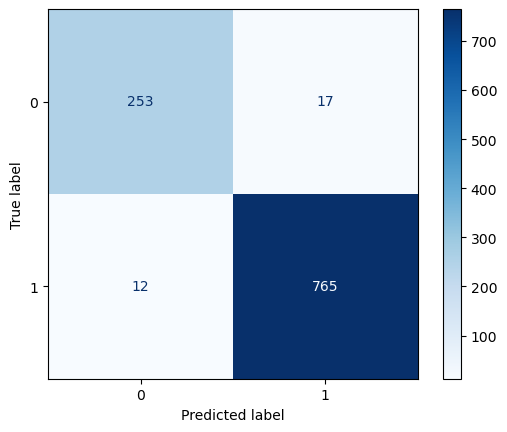

In [127]:
y_pred_prob = best_model.predict(X_test_expand)
y_pred = np.round(y_pred_prob).astype(int)  # Converti y_pred in int32 
# Calcola l'F1-score utilizzando la funzione f1_score modificata
test_f1 = f1_score(y_test, y_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")

# Calcola la confusion matrix utilizzando y_valid e y_pred
cm = confusion_matrix(y_test, y_pred)

# Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()